In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import preprocessing
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC,SVC


In [2]:
rng = np.random.RandomState(42)    

In [3]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',delimiter=';') #read data

In [4]:
target   = data['quality'] #the score of the wine. 

In [5]:
y = ['quality']

In [6]:
features = [i for i in data if i not in y] #this is used in importanceFeaturesPlot

In [7]:
X = [i for i in data if i not in y] #removes selected columns

In [8]:
X_train,X_test,y_train,y_test = train_test_split(
        data[X],data[y],test_size=0.33,random_state=rng)

In [9]:
scaler       = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train      = scaler.transform(X_train) #this converts pandas dataframe to numpy
X_test       = scaler.transform(X_test)

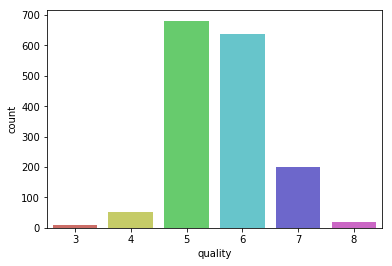

In [10]:
sns.countplot(x=target,palette='hls')
plt.show()

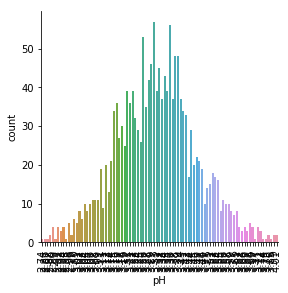

In [12]:
g = sns.factorplot(x='pH', data=data, kind="count")
g.set_xticklabels(rotation=90)
plt.show()

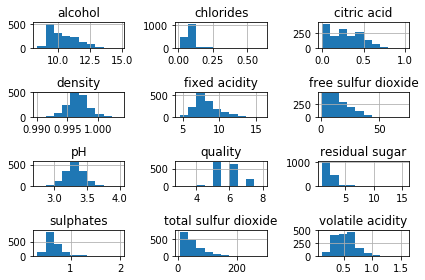

In [13]:
data.hist()
plt.tight_layout()#fit subplot in figure area
plt.show()


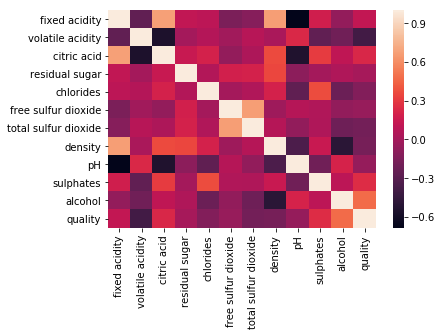

In [14]:
#heatmap idea from:
#https://towardsdatascience.com/predict-employee-turnover-with-python-da4975588aa3
g = sns.heatmap(data.corr())
for item in g.get_xticklabels():
    item.set_rotation(90)
for item in g.get_yticklabels():
    item.set_rotation(0)
plt.show()

In [15]:
print(data.groupby('quality').mean())#This returns the means of each feature at each wine score

         fixed acidity  volatile acidity  citric acid  residual sugar  \
quality                                                                 
3             8.360000          0.884500     0.171000        2.635000   
4             7.779245          0.693962     0.174151        2.694340   
5             8.167254          0.577041     0.243686        2.528855   
6             8.347179          0.497484     0.273824        2.477194   
7             8.872362          0.403920     0.375176        2.720603   
8             8.566667          0.423333     0.391111        2.577778   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
quality                                                                   
3         0.122500            11.000000             24.900000  0.997464   
4         0.090679            12.264151             36.245283  0.996542   
5         0.092736            16.983847             56.513950  0.997104   
6         0.084956            15.711599 

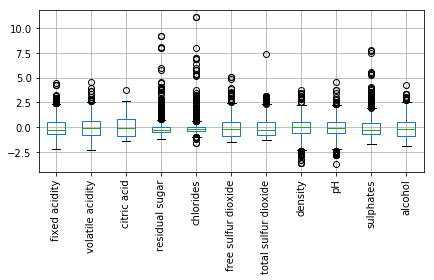

In [21]:
df_X_train = pd.DataFrame()


for i in range(len(features)):
    df_X_train[features[i]] = X_train[:,i]                
#df_X_train['A'] = X_train[:,0]
#print(np.shape(df_X_train))
df_X_train.boxplot(rot=90)
plt.tight_layout()#fit subplot in figure area
plt.show()


In [22]:
outliers_fraction = 0.04

In [23]:
clf_ell           = EllipticEnvelope(contamination = outliers_fraction)
clf_ell.fit(X_train)
ell_anomaly_score = clf_ell.decision_function(X_train)
ell_outliers      = clf_ell.predict(X_train)


In [24]:
clf_iforest = IsolationForest(n_estimators=100,random_state=rng,contamination = outliers_fraction)
clf_iforest.fit(X_train)
iforest_anomaly_score = clf_iforest.decision_function(X_train)
iforest_outliers = clf_iforest.predict(X_train)


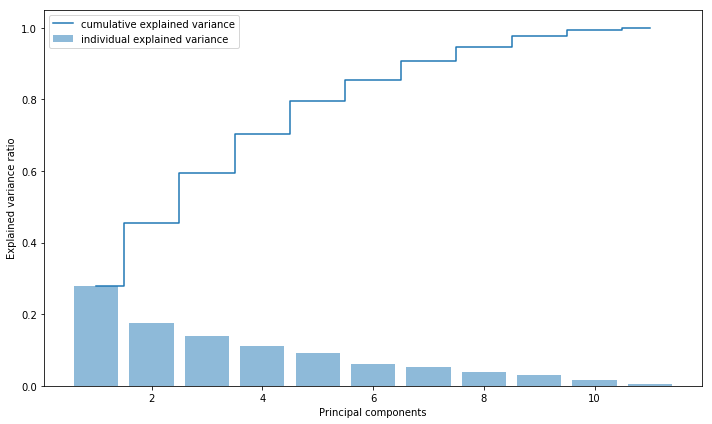

In [25]:
#Explained variance plot

#citations:
#1. Principal Component Analysis
#http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
#2. SCIKIT-LEARN : DATA COMPRESSION VIA DIMENSIONALITY REDUCTION I - PRINCIPAL COMPONENT ANALYSIS (PCA)
#http://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Data_Compresssion_via_Dimensionality_Reduction_1_Principal_component_analysis%20_PCA.php


cor_mat            = np.cov(X_train.T)
eig_vals, eig_vecs = np.linalg.eig(cor_mat)#eigen-decomposition of covariance matrix
eig_pairs          = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))] #list of eigenvalue,
                                                                                          #eigenvector tuples
eig_pairs.sort(key=lambda x: x[0], reverse=True) #sort the (eigenvalue,eigenvector)
                                                 #tuples list by eigenvalues


tot         = sum(eig_vals)
var_exp     = [(i / tot) for i in sorted(eig_vals, reverse=True)] # explained variance of ith eigenvalue =
                                                                  # \lambda_i/sum(lambda)
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(10, 6))
plt.bar(range(1,12), var_exp, alpha=0.5, align='center',
    label='individual explained variance')
plt.step(range(1,12), cum_var_exp, where='mid',
    label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()#fit subplot in figure area
plt.show()


In [26]:
components  = 3
pca         = PCA(n_components=components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.fit_transform(X_test)    


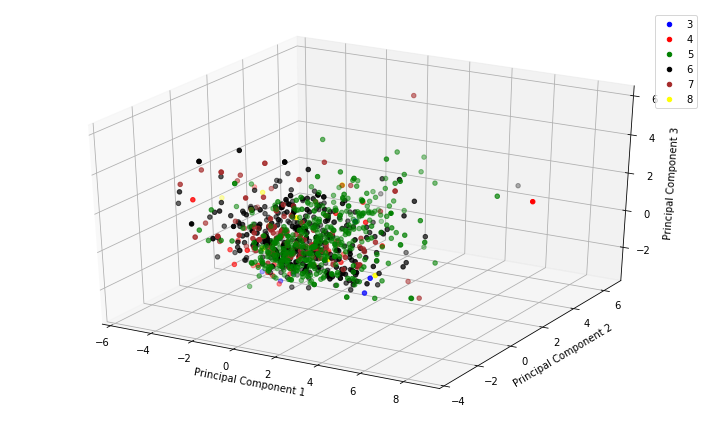

In [27]:
#3-component PCA plot

#citations:
#1. Principal Component Analysis
#http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
#2. SCIKIT-LEARN : DATA COMPRESSION VIA DIMENSIONALITY REDUCTION I - PRINCIPAL COMPONENT ANALYSIS (PCA)
#http://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Data_Compresssion_via_Dimensionality_Reduction_1_Principal_component_analysis%20_PCA.php
#3. In which I implement Anomaly Detection for a sample data set from Andrew Ng's Machine Learning Course.
#http://sdsawtelle.github.io/blog/output/week9-anomaly-andrew-ng-machine-learning-with-python.html

fig = plt.figure(figsize=(10, 6))
ax  = fig.add_subplot(111, projection='3d')
for lab, color in zip((3,4,5,6,7,8),
    ('blue', 'red', 'green','black','brown','yellow')):
    ax.scatter(X_train_pca[y_train.values.ravel()==lab, 0],
        X_train_pca[y_train.values.ravel()==lab, 1],
        X_train_pca[y_train.values.ravel()==lab, 2],
        label=lab,
        c=color)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend(loc='best')    
fig.tight_layout()
plt.show()


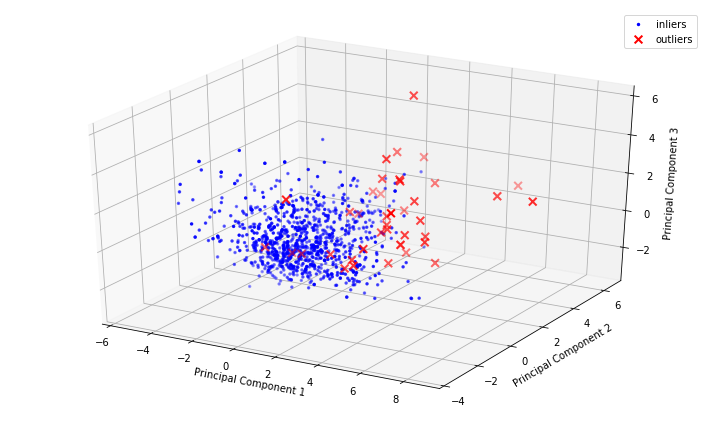

In [29]:
#Elliptic Envelope Outlier/Inlier plot projected onto 3-principal components 

#citations:
#1. In which I implement Anomaly Detection for a sample data set from Andrew Ng's Machine Learning Course.
#http://sdsawtelle.github.io/blog/output/week9-anomaly-andrew-ng-machine-learning-with-python.html

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train_pca[ell_outliers==1, 0],
    X_train_pca[ell_outliers==1, 1],
    X_train_pca[ell_outliers==1, 2],
    label='inliers',c='blue',lw=2,s=2)
        
ax.scatter(X_train_pca[ell_outliers==-1, 0],
    X_train_pca[ell_outliers==-1, 1],
    X_train_pca[ell_outliers==-1, 2],
    label='outliers',c='red',marker='x',lw=2,s=60)
        
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend(loc='best')    
fig.tight_layout()
plt.show()


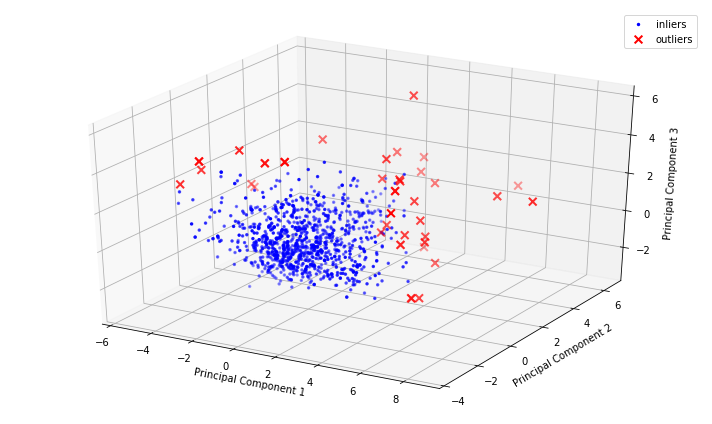

In [30]:
#Isolation Forest Outlier/Inlier plot projected onto 3-principal components 

#citations:
#1. In which I implement Anomaly Detection for a sample data set from Andrew Ng's Machine Learning Course.
#http://sdsawtelle.github.io/blog/output/week9-anomaly-andrew-ng-machine-learning-with-python.html

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train_pca[iforest_outliers==1, 0],
    X_train_pca[iforest_outliers==1, 1],
    X_train_pca[iforest_outliers==1, 2],
    label='inliers',c='blue',lw=2,s=2)
        
ax.scatter(X_train_pca[iforest_outliers==-1, 0],
    X_train_pca[iforest_outliers==-1, 1],
    X_train_pca[iforest_outliers==-1, 2],
    label='outliers',c='red',marker='x',lw=2,s=60)
        
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend(loc='best')    
fig.tight_layout()
plt.show()

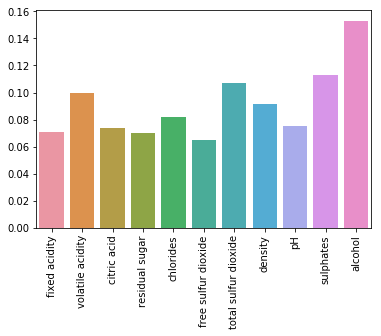

In [31]:
clf_rf      = RandomForestClassifier(n_estimators=300)    
clf_rf.fit(X_train,y_train.values.ravel())
importances = clf_rf.feature_importances_
g = sns.barplot(x=features, y=importances)
for item in g.get_xticklabels():
    item.set_rotation(90)
plt.show()


In [32]:
#The next two lines are for cross validation
c,r             = y_train.shape 
y_train_reshape = y_train.values.reshape(c,) #I need shape (1071,) not (1071,1) for cross val    


In [33]:
X_train_ell = X_train[ell_outliers==1]
y_train_ell = y_train[ell_outliers==1]


In [34]:
X_train_iforest = X_train[iforest_outliers==1]
y_train_iforest = y_train[iforest_outliers==1]


In [35]:
c,r                 = y_train_ell.shape 
y_train_ell_reshape = y_train_ell.values.reshape(c,) #I need shape (1071,) not (1071,1) for cross val   

In [36]:
c,r                     = y_train_iforest.shape 
y_train_iforest_reshape = y_train_iforest.values.reshape(c,) #I need shape (1071,) not (1071,1) for cross val 

In [37]:
print( '::::::logistic regression::::::\n')    
lam = [0.001,0.01,0.1,1.,10.,100.,1000.]
for l in lam:
    clf_logit  = LogisticRegression(multi_class='multinomial',solver='newton-cg',C=l)
    clf_logit.fit(X_train,y_train.values.ravel())
    pred_logit = clf_logit.predict(X_test)
    print( '\n \n::: with C = %f :::::: \n\n' %l )            
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_logit))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_logit))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_logit) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_logit,X_train,y_train_reshape,cv=5, scoring='accuracy')))


::::::logistic regression::::::


 
::: with C = 0.001000 :::::: 



accuracy = 0.534091 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  15   4   0   0]
 [  0   0 182  35   0   0]
 [  0   0 113 100   0   0]
 [  0   0   7  63   0   0]
 [  0   0   0   7   0   0]]
trace = 282 

cross val score = 0.571695 


 
::: with C = 0.010000 :::::: 



accuracy = 0.562500 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  13   6   0   0]
 [  0   0 169  48   0   0]
 [  0   0  88 124   1   0]
 [  0   0   5  61   4   0]
 [  0   0   0   6   1   0]]
trace = 297 

cross val score = 0.596958 


 
::: with C = 0.100000 :::::: 



accuracy = 0.575758 

confusion matrix: 
 
[[  0   1   1   0   0   0]
 [  0   0  11   8   0   0]
 [  0   0 167  50   0   0]
 [  0   0  78 123  12   0]
 [  0   0   5  51  14   0]
 [  0   0   0   2   5   0]]
trace = 304 

cross val score = 0.607199 


 
::: with C = 1.000000 :::::: 



accuracy = 0.571970 

confusion matrix: 
 
[[  1   0   1   0   0   0]
 [  0 

In [38]:
print( '::::::Outliers Remove (1) logistic regression::::::\n')    
lam = [0.001,0.01,0.1,1.,10.,100.,1000.]
for l in lam:
    clf_logit  = LogisticRegression(multi_class='multinomial',solver='newton-cg',C=l)
    clf_logit.fit(X_train_ell,y_train_ell.values.ravel())
    pred_logit = clf_logit.predict(X_test)
    print( '\n \n::: with C = %f :::::: \n\n' %l )            
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_logit))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_logit))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_logit) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_logit,X_train_ell,y_train_ell_reshape,cv=5, scoring='accuracy')))

::::::Outliers Remove (1) logistic regression::::::


 
::: with C = 0.001000 :::::: 



accuracy = 0.530303 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  15   4   0   0]
 [  0   0 181  36   0   0]
 [  0   0 114  99   0   0]
 [  0   0   6  64   0   0]
 [  0   0   0   7   0   0]]
trace = 280 

cross val score = 0.574281 


 
::: with C = 0.010000 :::::: 



accuracy = 0.562500 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  13   6   0   0]
 [  0   0 167  50   0   0]
 [  0   0  86 126   1   0]
 [  0   0   5  61   4   0]
 [  0   0   0   6   1   0]]
trace = 297 

cross val score = 0.594771 


 
::: with C = 0.100000 :::::: 



accuracy = 0.568182 

confusion matrix: 
 
[[  0   1   1   0   0   0]
 [  0   0  11   8   0   0]
 [  0   0 160  56   1   0]
 [  0   0  76 123  14   0]
 [  0   0   5  48  17   0]
 [  0   0   0   2   5   0]]
trace = 300 

cross val score = 0.604477 


 
::: with C = 1.000000 :::::: 



accuracy = 0.560606 

confusion matrix: 
 
[[  1   0   1

In [39]:
print( '::::::Outliers Remove (2) logistic regression::::::\n')    
lam = [0.001,0.01,0.1,1.,10.,100.,1000.]
for l in lam:
    clf_logit = LogisticRegression(multi_class='multinomial',solver='newton-cg',C=l)
    clf_logit.fit(X_train_iforest,y_train_iforest.values.ravel())
    pred_logit = clf_logit.predict(X_test)
    print( '\n \n::: with C = %f :::::: \n\n' %l )            
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_logit))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_logit))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_logit) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_logit,X_train_iforest,y_train_iforest_reshape,cv=5, scoring='accuracy')))

::::::Outliers Remove (2) logistic regression::::::


 
::: with C = 0.001000 :::::: 



accuracy = 0.535985 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  15   4   0   0]
 [  0   0 179  38   0   0]
 [  0   0 109 104   0   0]
 [  0   0   5  65   0   0]
 [  0   0   0   7   0   0]]
trace = 283 

cross val score = 0.577091 


 
::: with C = 0.010000 :::::: 



accuracy = 0.560606 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  12   7   0   0]
 [  0   0 165  52   0   0]
 [  0   0  85 127   1   0]
 [  0   0   5  61   4   0]
 [  0   0   0   6   1   0]]
trace = 296 

cross val score = 0.598566 


 
::: with C = 0.100000 :::::: 



accuracy = 0.566288 

confusion matrix: 
 
[[  0   1   1   0   0   0]
 [  0   0  12   7   0   0]
 [  0   0 157  60   0   0]
 [  0   0  72 125  16   0]
 [  0   0   5  48  17   0]
 [  0   0   0   2   5   0]]
trace = 299 

cross val score = 0.611132 


 
::: with C = 1.000000 :::::: 



accuracy = 0.562500 

confusion matrix: 
 
[[  1   0   1

In [40]:
print( '::::::PCA logistic regression::::::\n')    
lam = [0.001,0.01,0.1,1.,10.,100.,1000.]
for l in lam:
    clf_logit = LogisticRegression(multi_class='multinomial',solver='newton-cg',C=l)
    clf_logit.fit(X_train_pca,y_train.values.ravel())
    pred_logit = clf_logit.predict(X_test_pca)
    print( '\n \n::: with C = %f :::::: \n\n' %l )            
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_logit))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_logit))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_logit) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_logit,X_train_pca,y_train_reshape,cv=5, scoring='accuracy')))

::::::PCA logistic regression::::::


 
::: with C = 0.001000 :::::: 



accuracy = 0.524621 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  15   4   0   0]
 [  0   0 180  37   0   0]
 [  0   0 116  97   0   0]
 [  0   0  14  56   0   0]
 [  0   0   0   7   0   0]]
trace = 277 

cross val score = 0.548387 


 
::: with C = 0.010000 :::::: 



accuracy = 0.535985 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  14   5   0   0]
 [  0   0 166  51   0   0]
 [  0   0  97 115   1   0]
 [  0   0  11  57   2   0]
 [  0   0   0   7   0   0]]
trace = 283 

cross val score = 0.570766 


 
::: with C = 0.100000 :::::: 



accuracy = 0.530303 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  14   5   0   0]
 [  0   0 160  56   1   0]
 [  0   0  93 107  13   0]
 [  0   0  10  47  13   0]
 [  0   0   0   3   4   0]]
trace = 280 

cross val score = 0.585733 


 
::: with C = 1.000000 :::::: 



accuracy = 0.520833 

confusion matrix: 
 
[[  1   0   1   0   0   0]
 [

In [41]:
print( '\n::::::Decision Tree::::::\n')            
lam = [2,5,8,10,15,30,50,70,100,150]
for l in lam:
    clf_tree = DecisionTreeClassifier(max_depth=l)
    clf_tree.fit(X_train,y_train.values.ravel())
    pred_tree = clf_tree.predict(X_test)
    print( '\n \n::: with max_depth = %d :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_tree))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_tree))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_tree) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_tree,X_train,y_train_reshape,cv=5, scoring='accuracy')))



::::::Decision Tree::::::


 
::: with max_depth = 2 :::::: 



accuracy = 0.524621 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0   9  10   0   0]
 [  0   0 179  38   0   0]
 [  0   0 115  98   0   0]
 [  0   0  14  56   0   0]
 [  0   0   0   7   0   0]]
trace = 277 

cross val score = 0.554934 


 
::: with max_depth = 5 :::::: 



accuracy = 0.551136 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  13   6   0   0]
 [  0   1 172  42   2   0]
 [  0   0  98 100  15   0]
 [  0   0   9  42  19   0]
 [  0   0   0   5   2   0]]
trace = 291 

cross val score = 0.606133 


 
::: with max_depth = 8 :::::: 



accuracy = 0.556818 

confusion matrix: 
 
[[  0   1   0   1   0   0]
 [  0   0   9   8   2   0]
 [  0   5 153  55   4   0]
 [  0   4  67 115  27   0]
 [  0   1   8  34  26   1]
 [  0   0   0   4   3   0]]
trace = 294 

cross val score = 0.596720 


 
::: with max_depth = 10 :::::: 



accuracy = 0.562500 

confusion matrix: 
 
[[  0   1   1   0   0   0]
 [  0 

In [42]:
print( '\n::::::Outliers removed (1) Decision Tree::::::\n')            
lam = [2,5,8,10,15,30,50,70,100,150]
for l in lam:
    clf_tree = DecisionTreeClassifier(max_depth=l)
    clf_tree.fit(X_train_ell,y_train_ell.values.ravel())
    pred_tree = clf_tree.predict(X_test)
    print( '\n \n::: with max_depth = %d :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_tree))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_tree))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_tree) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_tree,X_train_ell,y_train_ell_reshape,cv=5, scoring='accuracy')))


::::::Outliers removed (1) Decision Tree::::::


 
::: with max_depth = 2 :::::: 



accuracy = 0.524621 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0   9  10   0   0]
 [  0   0 179  38   0   0]
 [  0   0 115  98   0   0]
 [  0   0  14  56   0   0]
 [  0   0   0   7   0   0]]
trace = 277 

cross val score = 0.547061 


 
::: with max_depth = 5 :::::: 



accuracy = 0.534091 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  14   5   0   0]
 [  0   1 166  49   1   0]
 [  0   0 101  98  14   0]
 [  0   0   8  44  18   0]
 [  0   0   0   3   4   0]]
trace = 282 

cross val score = 0.596462 


 
::: with max_depth = 8 :::::: 



accuracy = 0.541667 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0  10   7   2   0]
 [  0   6 139  70   2   0]
 [  2   2  62 127  20   0]
 [  0   2   4  44  19   1]
 [  0   0   0   4   2   1]]
trace = 286 

cross val score = 0.602449 


 
::: with max_depth = 10 :::::: 



accuracy = 0.554924 

confusion matrix: 
 
[[  0   2   

In [43]:
print( '\n::::::Outliers removed (2) Decision Tree::::::\n')            
lam = [2,5,8,10,15,30,50,70,100,150]
for l in lam:
    clf_tree = DecisionTreeClassifier(max_depth=l)
    clf_tree.fit(X_train_iforest,y_train_iforest.values.ravel())
    pred_tree = clf_tree.predict(X_test)
    print( '\n \n::: with max_depth = %d :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_tree))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_tree))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_tree) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_tree,X_train_iforest,y_train_iforest_reshape,cv=5, scoring='accuracy')))


::::::Outliers removed (2) Decision Tree::::::


 
::: with max_depth = 2 :::::: 



accuracy = 0.526515 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0   9   9   1   0]
 [  0   0 179  32   6   0]
 [  0   0 115  74  24   0]
 [  0   0  14  31  25   0]
 [  0   0   0   6   1   0]]
trace = 278 

cross val score = 0.552780 


 
::: with max_depth = 5 :::::: 



accuracy = 0.551136 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  11   8   0   0]
 [  0   0 166  48   3   0]
 [  0   0  94 108  11   0]
 [  0   0   8  45  17   0]
 [  0   0   0   4   3   0]]
trace = 291 

cross val score = 0.572091 


 
::: with max_depth = 8 :::::: 



accuracy = 0.543561 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  11   7   1   0]
 [  0   5 156  44  12   0]
 [  1   5  84 102  21   0]
 [  0   1  10  30  29   0]
 [  0   0   1   0   6   0]]
trace = 287 

cross val score = 0.573033 


 
::: with max_depth = 10 :::::: 



accuracy = 0.554924 

confusion matrix: 
 
[[  0   1   

In [44]:
print( '\n::::::PCA Decision Tree::::::\n')            
lam = [2,5,8,10,15,30,50,70,100,150]
for l in lam:
    clf_tree = DecisionTreeClassifier(max_depth=l)
    clf_tree.fit(X_train_pca,y_train.values.ravel())
    pred_tree = clf_tree.predict(X_test_pca)
    print( '\n \n::: with max_depth = %d :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_tree))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_tree))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_tree) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_tree,X_train_pca,y_train_reshape,cv=5, scoring='accuracy')))


::::::PCA Decision Tree::::::


 
::: with max_depth = 2 :::::: 



accuracy = 0.475379 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0  13   6   0   0]
 [  0   0 171  46   0   0]
 [  0   0 133  80   0   0]
 [  0   0  28  42   0   0]
 [  0   0   1   6   0   0]]
trace = 251 

cross val score = 0.538035 


 
::: with max_depth = 5 :::::: 



accuracy = 0.486742 

confusion matrix: 
 
[[  0   1   1   0   0   0]
 [  0   1  13   5   0   0]
 [  0   1 169  45   2   0]
 [  0   1 121  72  19   0]
 [  0   0  15  40  15   0]
 [  0   0   0   3   4   0]]
trace = 257 

cross val score = 0.575337 


 
::: with max_depth = 8 :::::: 



accuracy = 0.471591 

confusion matrix: 
 
[[  0   2   0   0   0   0]
 [  0   1  11   5   2   0]
 [  0   3 139  67   8   0]
 [  0   1  97  86  29   0]
 [  0   0  10  37  23   0]
 [  0   0   1   2   4   0]]
trace = 249 

cross val score = 0.576219 


 
::: with max_depth = 10 :::::: 



accuracy = 0.422348 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [

In [45]:
print( '\n::::::random forest::::::\n')
lam = [2,5,8,10,15,30,50,70,100,150]
#n_estimators = 300 best, acc=.669,trace=353
#default max_depth is best
for l in lam:
    clf_rf = RandomForestClassifier(n_estimators=300,max_depth=l)    
    clf_rf.fit(X_train,y_train.values.ravel())
    pred_rf = clf_rf.predict(X_test)
    print( '\n \n::: with max_depth = %d :::::: \n\n' %l )        
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_rf))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_rf))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_rf) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_rf,X_train,y_train_reshape,cv=5, scoring='accuracy')))        



::::::random forest::::::


 
::: with max_depth = 2 :::::: 



accuracy = 0.537879 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0   8  11   0   0]
 [  0   0 169  48   0   0]
 [  0   0  98 115   0   0]
 [  0   0   2  68   0   0]
 [  0   0   0   7   0   0]]
trace = 284 

cross val score = 0.589511 


 
::: with max_depth = 5 :::::: 



accuracy = 0.600379 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0   9  10   0   0]
 [  0   0 167  49   1   0]
 [  0   0  73 135   5   0]
 [  0   0   0  55  15   0]
 [  0   0   0   5   2   0]]
trace = 317 

cross val score = 0.627876 


 
::: with max_depth = 8 :::::: 



accuracy = 0.615530 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  10   9   0   0]
 [  0   0 166  49   2   0]
 [  0   0  61 138  14   0]
 [  0   0   0  49  21   0]
 [  0   0   0   2   5   0]]
trace = 325 

cross val score = 0.654826 


 
::: with max_depth = 10 :::::: 



accuracy = 0.640152 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0 

In [46]:
print( '\n::::::Outliers removed (1) random forest::::::\n')
lam = [2,5,8,10,15,30,50,70,100,150]
for l in lam:
    clf_rf = RandomForestClassifier(n_estimators=300,max_depth=l)    
    clf_rf.fit(X_train_ell,y_train_ell.values.ravel())
    pred_rf = clf_rf.predict(X_test)
    print( '\n \n::: with max_depth = %d :::::: \n\n' %l )        
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_rf))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_rf))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_rf) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_rf,X_train_ell,y_train_ell_reshape,cv=5, scoring='accuracy'))) 


::::::Outliers removed (1) random forest::::::


 
::: with max_depth = 2 :::::: 



accuracy = 0.560606 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0  10   9   0   0]
 [  0   0 173  44   0   0]
 [  0   0  90 123   0   0]
 [  0   0   1  69   0   0]
 [  0   0   0   7   0   0]]
trace = 296 

cross val score = 0.595741 


 
::: with max_depth = 5 :::::: 



accuracy = 0.598485 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0   8  11   0   0]
 [  0   0 167  49   1   0]
 [  0   0  71 136   6   0]
 [  0   0   0  57  13   0]
 [  0   0   0   4   3   0]]
trace = 316 

cross val score = 0.626889 


 
::: with max_depth = 8 :::::: 



accuracy = 0.615530 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  10   9   0   0]
 [  0   0 166  49   2   0]
 [  0   0  59 141  13   0]
 [  0   0   0  51  18   1]
 [  0   0   0   2   5   0]]
trace = 325 

cross val score = 0.655042 


 
::: with max_depth = 10 :::::: 



accuracy = 0.632576 

confusion matrix: 
 
[[  0   0   

In [47]:
print( '\n::::::Outliers removed (2) random forest::::::\n')
lam = [2,5,8,10,15,30,50,70,100,150]
for l in lam:
    clf_rf = RandomForestClassifier(n_estimators=300,max_depth=l)    
    clf_rf.fit(X_train_iforest,y_train_iforest.values.ravel())
    pred_rf = clf_rf.predict(X_test)
    print( '\n \n::: with max_depth = %d :::::: \n\n' %l )        
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_rf))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_rf))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_rf) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_rf,X_train_iforest,y_train_iforest_reshape,cv=5, scoring='accuracy'))) 


::::::Outliers removed (2) random forest::::::


 
::: with max_depth = 2 :::::: 



accuracy = 0.556818 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0   9  10   0   0]
 [  0   0 167  50   0   0]
 [  0   0  86 127   0   0]
 [  0   0   0  70   0   0]
 [  0   0   0   7   0   0]]
trace = 294 

cross val score = 0.597585 


 
::: with max_depth = 5 :::::: 



accuracy = 0.587121 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  10   9   0   0]
 [  0   0 164  52   1   0]
 [  0   0  73 132   8   0]
 [  0   0   0  56  14   0]
 [  0   0   0   4   3   0]]
trace = 310 

cross val score = 0.632568 


 
::: with max_depth = 8 :::::: 



accuracy = 0.626894 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  10   9   0   0]
 [  0   0 165  51   1   0]
 [  0   0  55 147  11   0]
 [  0   0   0  51  19   0]
 [  0   0   0   2   5   0]]
trace = 331 

cross val score = 0.656870 


 
::: with max_depth = 10 :::::: 



accuracy = 0.651515 

confusion matrix: 
 
[[  0   0   

In [48]:
print( '\n::::::PCA random forest::::::\n')
lam = [2,5,8,10,15,30,50,70,100,150]
for l in lam:
    clf_rf = RandomForestClassifier(n_estimators=300,max_depth=l)    
    clf_rf.fit(X_train_pca,y_train.values.ravel())
    pred_rf = clf_rf.predict(X_test_pca)
    print( '\n \n::: with max_depth = %d :::::: \n\n' %l )        
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_rf))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_rf))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_rf) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_rf,X_train_pca,y_train_reshape,cv=5, scoring='accuracy')))        



::::::PCA random forest::::::


 
::: with max_depth = 2 :::::: 



accuracy = 0.532197 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  14   5   0   0]
 [  0   0 174  43   0   0]
 [  0   0 106 107   0   0]
 [  0   0  13  57   0   0]
 [  0   0   0   7   0   0]]
trace = 281 

cross val score = 0.581002 


 
::: with max_depth = 5 :::::: 



accuracy = 0.513258 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  13   6   0   0]
 [  0   0 150  65   2   0]
 [  0   0  93 110  10   0]
 [  0   0   8  51  11   0]
 [  0   0   0   4   3   0]]
trace = 271 

cross val score = 0.605302 


 
::: with max_depth = 8 :::::: 



accuracy = 0.524621 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  14   5   0   0]
 [  0   0 151  63   3   0]
 [  0   0  90 110  13   0]
 [  0   0   9  45  16   0]
 [  0   0   0   5   2   0]]
trace = 277 

cross val score = 0.619278 


 
::: with max_depth = 10 :::::: 



accuracy = 0.517045 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [

In [43]:
print( '\n::::::Adaboost::::::\n')
lam = [1,2,4,10,50,100]    
for l in lam:
    clf_ada = AdaBoostClassifier(n_estimators=l)
    clf_ada.fit(X_train,y_train.values.ravel())
    pred_ada = clf_ada.predict(X_test)

    print( '\n \n::: with n_estimators = %d :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_ada))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_ada))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_ada) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_ada,X_train,y_train_reshape,cv=5, scoring='accuracy'))) 



::::::Adaboost::::::


 
::: with n_estimators = 1 :::::: 



accuracy = 0.524621 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0   9  10   0   0]
 [  0   0 179  38   0   0]
 [  0   0 115  98   0   0]
 [  0   0  14  56   0   0]
 [  0   0   0   7   0   0]]
trace = 277 

cross val score = 0.554934 


 
::: with n_estimators = 2 :::::: 



accuracy = 0.524621 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0   9  10   0   0]
 [  0   0 179  38   0   0]
 [  0   0 115  98   0   0]
 [  0   0  14  56   0   0]
 [  0   0   0   7   0   0]]
trace = 277 

cross val score = 0.556777 


 
::: with n_estimators = 4 :::::: 



accuracy = 0.518939 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0   9  10   0   0]
 [  3   0 176  38   0   0]
 [  0   0 115  98   0   0]
 [  0   0  14  56   0   0]
 [  0   0   0   7   0   0]]
trace = 274 

cross val score = 0.554921 


 
::: with n_estimators = 10 :::::: 



accuracy = 0.518939 

confusion matrix: 
 
[[  0   0   1   1   0   0]

In [44]:
print( '\n::::::Outliers removed (1) Adaboost::::::\n')
lam = [1,2,4,10,50,100]    
for l in lam:
    clf_ada = AdaBoostClassifier(n_estimators=l)
    clf_ada.fit(X_train_ell,y_train_ell.values.ravel())
    pred_ada = clf_ada.predict(X_test)

    print( '\n \n::: with n_estimators = %d :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_ada))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_ada))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_ada) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_ada,X_train_ell,y_train_ell_reshape,cv=5, scoring='accuracy'))) 



::::::Outliers removed (1) Adaboost::::::


 
::: with n_estimators = 1 :::::: 



accuracy = 0.524621 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0   9  10   0   0]
 [  0   0 179  38   0   0]
 [  0   0 115  98   0   0]
 [  0   0  14  56   0   0]
 [  0   0   0   7   0   0]]
trace = 277 

cross val score = 0.551892 


 
::: with n_estimators = 2 :::::: 



accuracy = 0.526515 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  13   6   0   0]
 [  0   0 182  35   0   0]
 [  0   0 117  96   0   0]
 [  0   0  14  56   0   0]
 [  0   0   0   7   0   0]]
trace = 278 

cross val score = 0.558647 


 
::: with n_estimators = 4 :::::: 



accuracy = 0.515152 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  12   7   0   0]
 [  2   0 163  52   0   0]
 [  2   0 102 109   0   0]
 [  0   0  14  56   0   0]
 [  0   0   0   7   0   0]]
trace = 272 

cross val score = 0.557661 


 
::: with n_estimators = 10 :::::: 



accuracy = 0.515152 

confusion matrix: 
 
[[  0

In [45]:
print( '\n::::::Outliers removed (2) Adaboost::::::\n')
lam = [1,2,4,10,50,100]    
for l in lam:
    clf_ada = AdaBoostClassifier(n_estimators=l)
    clf_ada.fit(X_train_iforest,y_train_iforest.values.ravel())
    pred_ada = clf_ada.predict(X_test)

    print( '\n \n::: with n_estimators = %d :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_ada))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_ada))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_ada) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_ada,X_train_iforest,y_train_iforest_reshape,cv=5, scoring='accuracy'))) 


::::::Outliers removed (2) Adaboost::::::


 
::: with n_estimators = 1 :::::: 



accuracy = 0.524621 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0   9  10   0   0]
 [  0   0 179  38   0   0]
 [  0   0 115  98   0   0]
 [  0   0  14  56   0   0]
 [  0   0   0   7   0   0]]
trace = 277 

cross val score = 0.554717 


 
::: with n_estimators = 2 :::::: 



accuracy = 0.524621 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0   9  10   0   0]
 [  0   0 179  38   0   0]
 [  0   0 115  98   0   0]
 [  0   0  14  56   0   0]
 [  0   0   0   7   0   0]]
trace = 277 

cross val score = 0.556649 


 
::: with n_estimators = 4 :::::: 



accuracy = 0.507576 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0   9  10   0   0]
 [  3   0 163  51   0   0]
 [  0   0 108 105   0   0]
 [  0   0  14  56   0   0]
 [  0   0   0   7   0   0]]
trace = 268 

cross val score = 0.557630 


 
::: with n_estimators = 10 :::::: 



accuracy = 0.507576 

confusion matrix: 
 
[[  0

In [46]:
print( '\n::::::PCA Adaboost::::::\n')
lam = [1,2,4,10,50,100]    
for l in lam:
    clf_ada = AdaBoostClassifier(n_estimators=l)
    clf_ada.fit(X_train_pca,y_train.values.ravel())
    pred_ada = clf_ada.predict(X_test_pca)

    print( '\n \n::: with n_estimators = %d :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_ada))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_ada))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_ada) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_ada,X_train_pca,y_train_reshape,cv=5, scoring='accuracy'))) 


::::::PCA Adaboost::::::


 
::: with n_estimators = 1 :::::: 



accuracy = 0.475379 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0  13   6   0   0]
 [  0   0 171  46   0   0]
 [  0   0 133  80   0   0]
 [  0   0  28  42   0   0]
 [  0   0   1   6   0   0]]
trace = 251 

cross val score = 0.538035 


 
::: with n_estimators = 2 :::::: 



accuracy = 0.501894 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0  12   7   0   0]
 [  0   0 167  50   0   0]
 [  0   0 113  88  12   0]
 [  0   0  17  43  10   0]
 [  0   0   0   5   2   0]]
trace = 265 

cross val score = 0.541774 


 
::: with n_estimators = 4 :::::: 



accuracy = 0.490530 

confusion matrix: 
 
[[  0   0   1   1   0   0]
 [  0   0  12   7   0   0]
 [  0   0 167  50   0   0]
 [  0   0 113  88   4   8]
 [  0   0  17  43   2   8]
 [  0   0   0   5   0   2]]
trace = 259 

cross val score = 0.535240 


 
::: with n_estimators = 10 :::::: 



accuracy = 0.490530 

confusion matrix: 
 
[[  0   0   1   1   0 

In [47]:
print( '\n::::::gradient boosting::::::\n')
lam = [1,2,3,5,6,10,15,20,30,50,100]
#random forest
#n_estimators = 300 best, acc=.669,trace=353
#default max_depth is best

#gradient boosting
#n_estimators = 300 best, acc=.652,trace=344
#default max_depth is best
for l in lam:
    clf_gbm = GradientBoostingClassifier(n_estimators=300,max_depth=l)    
    clf_gbm.fit(X_train,y_train.values.ravel())
    pred_gbm = clf_gbm.predict(X_test)
    print( '\n \n::: with max_depth = %d :::::: \n\n' %l )        
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_gbm))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_gbm))#column for each possible score
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_gbm) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_gbm,X_train,y_train_reshape,cv=5, scoring='accuracy'))) 



::::::gradient boosting::::::


 
::: with max_depth = 1 :::::: 



accuracy = 0.587121 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   2   8   9   0   0]
 [  2   2 159  51   3   0]
 [  2   0  64 128  17   2]
 [  0   0   3  46  21   0]
 [  0   0   0   4   3   0]]
trace = 310 

cross val score = 0.605348 


 
::: with max_depth = 2 :::::: 



accuracy = 0.617424 

confusion matrix: 
 
[[  0   1   1   0   0   0]
 [  0   2  10   7   0   0]
 [  3   2 158  50   4   0]
 [  2   0  52 137  20   2]
 [  0   0   4  38  28   0]
 [  0   0   0   2   4   1]]
trace = 326 

cross val score = 0.618464 


 
::: with max_depth = 3 :::::: 



accuracy = 0.630682 

confusion matrix: 
 
[[  0   1   1   0   0   0]
 [  0   2   9   8   0   0]
 [  2   4 158  49   4   0]
 [  1   0  52 139  19   2]
 [  0   0   7  29  33   1]
 [  0   0   0   3   3   1]]
trace = 333 

cross val score = 0.639851 


 
::: with max_depth = 5 :::::: 



accuracy = 0.623106 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [ 

In [48]:
print( '\n::::::Outliers removed (1) gradient boosting::::::\n')
lam = [1,2,3,5,6,10,15,20,30,50,100]
for l in lam:
    clf_gbm = GradientBoostingClassifier(n_estimators=300,max_depth=l)    
    clf_gbm.fit(X_train_ell,y_train_ell.values.ravel())
    pred_gbm = clf_gbm.predict(X_test)
    print( '\n \n::: with max_depth = %d :::::: \n\n' %l )        
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_gbm))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_gbm))#column for each possible score
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_gbm) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_gbm,X_train_ell,y_train_ell_reshape,cv=5, scoring='accuracy'))) 


::::::Outliers removed (1) gradient boosting::::::


 
::: with max_depth = 1 :::::: 



accuracy = 0.585227 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   2  11   6   0   0]
 [  2   2 155  56   2   0]
 [  2   0  62 130  17   2]
 [  0   0   6  42  22   0]
 [  0   0   0   4   3   0]]
trace = 309 

cross val score = 0.604359 


 
::: with max_depth = 2 :::::: 



accuracy = 0.617424 

confusion matrix: 
 
[[  0   1   1   0   0   0]
 [  0   2  10   7   0   0]
 [  3   2 166  42   4   0]
 [  2   1  60 128  20   2]
 [  0   0   2  38  29   1]
 [  0   0   0   4   2   1]]
trace = 326 

cross val score = 0.628783 


 
::: with max_depth = 3 :::::: 



accuracy = 0.638258 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  1   3   7   8   0   0]
 [  2   1 169  43   2   0]
 [  2   0  58 128  22   3]
 [  0   0   4  29  36   1]
 [  0   0   0   1   5   1]]
trace = 337 

cross val score = 0.641369 


 
::: with max_depth = 5 :::::: 



accuracy = 0.626894 

confusion matrix: 
 
[[  0   0

In [49]:
print( '\n::::::Outliers removed (2) gradient boosting::::::\n')
lam = [1,2,3,5,6,10,15,20,30,50,100]
for l in lam:
    clf_gbm = GradientBoostingClassifier(n_estimators=300,max_depth=l)    
    clf_gbm.fit(X_train_iforest,y_train_iforest.values.ravel())
    pred_gbm = clf_gbm.predict(X_test)
    print( '\n \n::: with max_depth = %d :::::: \n\n' %l )        
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_gbm))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_gbm))#column for each possible score
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_gbm) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_gbm,X_train_iforest,y_train_iforest_reshape,cv=5, scoring='accuracy'))) 


::::::Outliers removed (2) gradient boosting::::::


 
::: with max_depth = 1 :::::: 



accuracy = 0.600379 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   2   8   9   0   0]
 [  2   2 160  51   2   0]
 [  2   0  61 131  16   3]
 [  0   0   5  41  24   0]
 [  0   0   0   4   3   0]]
trace = 317 

cross val score = 0.611957 


 
::: with max_depth = 2 :::::: 



accuracy = 0.626894 

confusion matrix: 
 
[[  0   1   1   0   0   0]
 [  1   2   9   7   0   0]
 [  2   3 166  43   3   0]
 [  3   0  54 134  19   3]
 [  0   0   2  38  28   2]
 [  0   0   0   3   3   1]]
trace = 331 

cross val score = 0.638398 


 
::: with max_depth = 3 :::::: 



accuracy = 0.630682 

confusion matrix: 
 
[[  0   1   1   0   0   0]
 [  1   1   8   9   0   0]
 [  2   1 164  47   3   0]
 [  3   0  52 134  21   3]
 [  0   0   5  30  33   2]
 [  0   0   0   4   2   1]]
trace = 333 

cross val score = 0.634430 


 
::: with max_depth = 5 :::::: 



accuracy = 0.625000 

confusion matrix: 
 
[[  0   0

In [50]:
print( '\n::::::PCA gradient boosting::::::\n')
lam = [1,2,3,5,6,10,15,20,30,50,100]
for l in lam:
    clf_gbm = GradientBoostingClassifier(n_estimators=300,max_depth=l)    
    clf_gbm.fit(X_train_pca,y_train.values.ravel())
    pred_gbm = clf_gbm.predict(X_test_pca)
    print( '\n \n::: with max_depth = %d :::::: \n\n' %l )        
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_gbm))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_gbm))#column for each possible score
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_gbm) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_gbm,X_train_pca,y_train_reshape,cv=5, scoring='accuracy')))


::::::PCA gradient boosting::::::


 
::: with max_depth = 1 :::::: 



accuracy = 0.505682 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  1   0  12   6   0   0]
 [  1   1 144  68   3   0]
 [  0   3  85 105  19   1]
 [  0   0   7  46  17   0]
 [  0   0   0   2   4   1]]
trace = 267 

cross val score = 0.596914 


 
::: with max_depth = 2 :::::: 



accuracy = 0.498106 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  2   0  14   3   0   0]
 [  2   3 140  67   5   0]
 [  2   7  79 100  23   2]
 [  0   0  10  37  23   0]
 [  0   0   0   3   4   0]]
trace = 263 

cross val score = 0.597940 


 
::: with max_depth = 3 :::::: 



accuracy = 0.462121 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  2   1  14   2   0   0]
 [  2   6 136  68   4   1]
 [  2   9  87  86  28   1]
 [  0   0  12  37  21   0]
 [  0   0   0   3   4   0]]
trace = 244 

cross val score = 0.598879 


 
::: with max_depth = 5 :::::: 



accuracy = 0.469697 

confusion matrix: 
 
[[  0   0   2   0   0   0]

In [51]:
print( '\n::::::Linear SVM::::::\n')
lam = [0.001,0.01,0.02,0.04,0.06,0.08,0.10,1.0,5.0]    
for l in lam:
    clf_lsvm = LinearSVC(C=l)
    clf_lsvm.fit(X_train,y_train.values.ravel())
    pred_lsvm = clf_lsvm.predict(X_test)
    print( '\n \n::: with C = %f :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_lsvm))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_lsvm))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_lsvm) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_lsvm,X_train,y_train_reshape,cv=5, scoring='accuracy'))) 



::::::Linear SVM::::::


 
::: with C = 0.001000 :::::: 



accuracy = 0.543561 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  13   6   0   0]
 [  0   0 173  44   0   0]
 [  0   0  99 114   0   0]
 [  0   0   5  65   0   0]
 [  0   0   0   7   0   0]]
trace = 287 

cross val score = 0.586633 


 
::: with C = 0.010000 :::::: 



accuracy = 0.556818 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  13   6   0   0]
 [  0   0 172  45   0   0]
 [  0   0  91 121   1   0]
 [  0   0   5  64   1   0]
 [  0   0   0   6   1   0]]
trace = 294 

cross val score = 0.596023 


 
::: with C = 0.020000 :::::: 



accuracy = 0.560606 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  13   6   0   0]
 [  0   0 171  46   0   0]
 [  0   0  88 124   1   0]
 [  0   0   5  64   1   0]
 [  0   0   0   6   1   0]]
trace = 296 

cross val score = 0.590402 


 
::: with C = 0.040000 :::::: 



accuracy = 0.562500 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  13 

In [52]:
print( '\n::::::Outliers removed (1) Linear SVM::::::\n')
lam = [0.001,0.01,0.02,0.04,0.06,0.08,0.10,1.0,5.0]    
for l in lam:
    clf_lsvm = LinearSVC(C=l)
    clf_lsvm.fit(X_train_ell,y_train_ell.values.ravel())
    pred_lsvm = clf_lsvm.predict(X_test)
    print( '\n \n::: with C = %f :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_lsvm))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_lsvm))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_lsvm) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_lsvm,X_train_ell,y_train_ell_reshape,cv=5, scoring='accuracy'))) 


::::::Outliers removed (1) Linear SVM::::::


 
::: with C = 0.001000 :::::: 



accuracy = 0.551136 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  12   6   1   0]
 [  0   0 173  44   0   0]
 [  0   0  97 115   1   0]
 [  0   0   5  62   3   0]
 [  0   0   0   7   0   0]]
trace = 291 

cross val score = 0.585886 


 
::: with C = 0.010000 :::::: 



accuracy = 0.556818 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  14   5   0   0]
 [  0   0 167  50   0   0]
 [  0   0  88 124   1   0]
 [  0   0   7  60   3   0]
 [  0   0   0   6   1   0]]
trace = 294 

cross val score = 0.589869 


 
::: with C = 0.020000 :::::: 



accuracy = 0.564394 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  14   5   0   0]
 [  0   0 166  51   0   0]
 [  0   0  83 129   1   0]
 [  0   0   7  60   3   0]
 [  0   0   0   6   1   0]]
trace = 298 

cross val score = 0.589860 


 
::: with C = 0.040000 :::::: 



accuracy = 0.568182 

confusion matrix: 
 
[[  0   0   2   0   

In [53]:
print( '\n::::::Outliers removed (2) Linear SVM::::::\n')
lam = [0.001,0.01,0.02,0.04,0.06,0.08,0.10,1.0,5.0]    
for l in lam:
    clf_lsvm = LinearSVC(C=l)
    clf_lsvm.fit(X_train_iforest,y_train_iforest.values.ravel())
    pred_lsvm = clf_lsvm.predict(X_test)
    print( '\n \n::: with C = %f :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_lsvm))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_lsvm))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_lsvm) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_lsvm,X_train_iforest,y_train_iforest_reshape,cv=5, scoring='accuracy'))) 


::::::Outliers removed (2) Linear SVM::::::


 
::: with C = 0.001000 :::::: 



accuracy = 0.551136 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  13   6   0   0]
 [  0   0 171  46   0   0]
 [  0   0  93 120   0   0]
 [  0   0   5  65   0   0]
 [  0   0   0   7   0   0]]
trace = 291 

cross val score = 0.593668 


 
::: with C = 0.010000 :::::: 



accuracy = 0.551136 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  12   7   0   0]
 [  0   0 164  53   0   0]
 [  0   0  86 126   1   0]
 [  0   0   5  64   1   0]
 [  0   0   0   6   1   0]]
trace = 291 

cross val score = 0.586844 


 
::: with C = 0.020000 :::::: 



accuracy = 0.560606 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  12   7   0   0]
 [  0   0 163  54   0   0]
 [  0   0  80 131   2   0]
 [  0   0   5  63   2   0]
 [  0   0   0   6   1   0]]
trace = 296 

cross val score = 0.591746 


 
::: with C = 0.040000 :::::: 



accuracy = 0.566288 

confusion matrix: 
 
[[  0   0   2   0   

In [54]:
print( '\n::::::PCA Linear SVM::::::\n')
lam = [0.001,0.01,0.02,0.04,0.06,0.08,0.10,1.0,5.0]    
for l in lam:
    clf_lsvm = LinearSVC(C=l)
    clf_lsvm.fit(X_train_pca,y_train.values.ravel())
    pred_lsvm = clf_lsvm.predict(X_test_pca)
    print( '\n \n::: with C = %f :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_lsvm))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_lsvm))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_lsvm) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_lsvm,X_train_pca,y_train_reshape,cv=5, scoring='accuracy'))) 


::::::PCA Linear SVM::::::


 
::: with C = 0.001000 :::::: 



accuracy = 0.532197 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  15   4   0   0]
 [  0   0 173  44   0   0]
 [  0   0 105 108   0   0]
 [  0   0  12  58   0   0]
 [  0   0   0   7   0   0]]
trace = 281 

cross val score = 0.566123 


 
::: with C = 0.010000 :::::: 



accuracy = 0.537879 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  15   4   0   0]
 [  0   0 177  40   0   0]
 [  0   0 106 107   0   0]
 [  0   0  12  58   0   0]
 [  0   0   0   7   0   0]]
trace = 284 

cross val score = 0.559572 


 
::: with C = 0.020000 :::::: 



accuracy = 0.537879 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  15   4   0   0]
 [  0   0 177  40   0   0]
 [  0   0 106 107   0   0]
 [  0   0  12  58   0   0]
 [  0   0   0   7   0   0]]
trace = 284 

cross val score = 0.559576 


 
::: with C = 0.040000 :::::: 



accuracy = 0.537879 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0 

In [55]:
print( '\n::::::SVM rbf::::::\n')
lam = [0.001,0.01,0.02,0.04,0.06,0.08,0.10,1.0,5.0]    
for l in lam:
    clf_kernel_svm = SVC(kernel='rbf',C=l)
    clf_kernel_svm.fit(X_train,y_train.values.ravel())
    pred_kernel_svm = clf_kernel_svm.predict(X_test)    
    print( '\n \n::: with C = %f :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_kernel_svm))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_kernel_svm))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_kernel_svm) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_kernel_svm,X_train,y_train_reshape,cv=5, scoring='accuracy')))



::::::SVM rbf::::::


 
::: with C = 0.001000 :::::: 



accuracy = 0.410985 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  19   0   0   0]
 [  0   0 217   0   0   0]
 [  0   0 213   0   0   0]
 [  0   0  70   0   0   0]
 [  0   0   7   0   0   0]]
trace = 217 

cross val score = 0.433254 


 
::: with C = 0.010000 :::::: 



accuracy = 0.410985 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  19   0   0   0]
 [  0   0 217   0   0   0]
 [  0   0 213   0   0   0]
 [  0   0  70   0   0   0]
 [  0   0   7   0   0   0]]
trace = 217 

cross val score = 0.433254 


 
::: with C = 0.020000 :::::: 



accuracy = 0.486742 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  18   1   0   0]
 [  0   0 202  15   0   0]
 [  0   0 158  55   0   0]
 [  0   0  25  45   0   0]
 [  0   0   2   5   0   0]]
trace = 257 

cross val score = 0.465835 


 
::: with C = 0.040000 :::::: 



accuracy = 0.553030 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  13   6

In [56]:
print( '\n::::::Outliers removed (1) SVM rbf::::::\n')
lam = [0.001,0.01,0.02,0.04,0.06,0.08,0.10,1.0,5.0]    
for l in lam:
    clf_kernel_svm = SVC(kernel='rbf',C=l)
    clf_kernel_svm.fit(X_train_ell,y_train_ell.values.ravel())
    pred_kernel_svm = clf_kernel_svm.predict(X_test)    
    print( '\n \n::: with C = %f :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_kernel_svm))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_kernel_svm))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_kernel_svm) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_kernel_svm,X_train_ell,y_train_ell_reshape,cv=5, scoring='accuracy')))


::::::Outliers removed (1) SVM rbf::::::


 
::: with C = 0.001000 :::::: 



accuracy = 0.410985 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  19   0   0   0]
 [  0   0 217   0   0   0]
 [  0   0 213   0   0   0]
 [  0   0  70   0   0   0]
 [  0   0   7   0   0   0]]
trace = 217 

cross val score = 0.427077 


 
::: with C = 0.010000 :::::: 



accuracy = 0.410985 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  19   0   0   0]
 [  0   0 217   0   0   0]
 [  0   0 213   0   0   0]
 [  0   0  70   0   0   0]
 [  0   0   7   0   0   0]]
trace = 217 

cross val score = 0.427077 


 
::: with C = 0.020000 :::::: 



accuracy = 0.509470 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  18   1   0   0]
 [  0   0 199  18   0   0]
 [  0   0 143  70   0   0]
 [  0   0  20  50   0   0]
 [  0   0   1   6   0   0]]
trace = 269 

cross val score = 0.483295 


 
::: with C = 0.040000 :::::: 



accuracy = 0.549242 

confusion matrix: 
 
[[  0   0   2   0   0  

In [57]:
print( '\n::::::Outliers removed (2) SVM rbf::::::\n')
lam = [0.001,0.01,0.02,0.04,0.06,0.08,0.10,1.0,5.0]    
for l in lam:
    clf_kernel_svm = SVC(kernel='rbf',C=l)
    clf_kernel_svm.fit(X_train_iforest,y_train_iforest.values.ravel())
    pred_kernel_svm = clf_kernel_svm.predict(X_test)    
    print( '\n \n::: with C = %f :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_kernel_svm))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_kernel_svm))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_kernel_svm) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_kernel_svm,X_train_iforest,y_train_iforest_reshape,cv=5, scoring='accuracy')))


::::::Outliers removed (2) SVM rbf::::::


 
::: with C = 0.001000 :::::: 



accuracy = 0.410985 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  19   0   0   0]
 [  0   0 217   0   0   0]
 [  0   0 213   0   0   0]
 [  0   0  70   0   0   0]
 [  0   0   7   0   0   0]]
trace = 217 

cross val score = 0.429007 


 
::: with C = 0.010000 :::::: 



accuracy = 0.410985 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  19   0   0   0]
 [  0   0 217   0   0   0]
 [  0   0 213   0   0   0]
 [  0   0  70   0   0   0]
 [  0   0   7   0   0   0]]
trace = 217 

cross val score = 0.429007 


 
::: with C = 0.020000 :::::: 



accuracy = 0.515152 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  17   2   0   0]
 [  0   0 195  22   0   0]
 [  0   0 136  77   0   0]
 [  0   0  17  53   0   0]
 [  0   0   1   6   0   0]]
trace = 272 

cross val score = 0.489267 


 
::: with C = 0.040000 :::::: 



accuracy = 0.556818 

confusion matrix: 
 
[[  0   0   2   0   0  

In [58]:
print( '\n::::::PCA SVM rbf::::::\n')
lam = [0.001,0.01,0.02,0.04,0.06,0.08,0.10,1.0,5.0]    
for l in lam:
    clf_kernel_svm = SVC(kernel='rbf',C=l)
    clf_kernel_svm.fit(X_train_pca,y_train.values.ravel())
    pred_kernel_svm = clf_kernel_svm.predict(X_test_pca)    
    print( '\n \n::: with C = %f :::::: \n\n' %l )
    print('\naccuracy = %f \n' % accuracy_score(y_test,pred_kernel_svm))
    print('confusion matrix: \n ')
    print(confusion_matrix(y_test,pred_kernel_svm))
    print('trace = %d \n' % np.trace(confusion_matrix(y_test,pred_kernel_svm) ) )
    print('cross val score = %f \n' %
        np.average(cross_val_score(clf_kernel_svm,X_train_pca,y_train_reshape,cv=5, scoring='accuracy')))


::::::PCA SVM rbf::::::


 
::: with C = 0.001000 :::::: 



accuracy = 0.410985 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  19   0   0   0]
 [  0   0 217   0   0   0]
 [  0   0 213   0   0   0]
 [  0   0  70   0   0   0]
 [  0   0   7   0   0   0]]
trace = 217 

cross val score = 0.433254 


 
::: with C = 0.010000 :::::: 



accuracy = 0.410985 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  19   0   0   0]
 [  0   0 217   0   0   0]
 [  0   0 213   0   0   0]
 [  0   0  70   0   0   0]
 [  0   0   7   0   0   0]]
trace = 217 

cross val score = 0.433254 


 
::: with C = 0.020000 :::::: 



accuracy = 0.511364 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  17   2   0   0]
 [  0   0 190  27   0   0]
 [  0   0 133  80   0   0]
 [  0   0  21  49   0   0]
 [  0   0   2   5   0   0]]
trace = 270 

cross val score = 0.500496 


 
::: with C = 0.040000 :::::: 



accuracy = 0.534091 

confusion matrix: 
 
[[  0   0   2   0   0   0]
 [  0   0  15